In [1]:
from models.mobilenetv2 import *
from models.resnet34 import *
from models.vgg import *
import pickle
import torch
import numpy as np
import torchvision.datasets as dset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets.cifar import CIFAR10, CIFAR100
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import json

In [2]:
MODELS = {"resnet34": resnet_34, "vgg16": vgg_16, "mobilenetv2": mobilenet_v2}
INPUT_SIZE = {"resnet34": 32, "vgg16": 32, "mobilenetv2": 32}
DATASETS = {"cifar10": 10, "cifar100": 100, "tinyimagenet": 200}
ROOT_DIR = "."
BATCH_SIZE=100
NUM_WORKERS=2
DEVICE="cuda:1"

In [3]:
def get_model(model, dataset):
    net = MODELS[model](DATASETS[dataset])
    net.load_state_dict(torch.load(f"{ROOT_DIR}/models/{model}_{dataset}.pth")['net'])
    return net

def get_dset(model, dataset, mode="eval"):
    filename = f"{ROOT_DIR}/datasets/{mode}/{dataset}_{model}.p"
    with open(filename, "rb") as f:
        dataset = pickle.load(f)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=(mode=="eval"), num_workers=NUM_WORKERS)
    return dataloader

In [4]:
def max_softmax(logits):
    score, _ = torch.max(F.softmax(logits, 1), 1)
    return score.detach().cpu().data.numpy()

def entropy(logits):
    return Categorical(logits=logits).entropy().detach().cpu().data.numpy()

def mod_entropy(softprob, labels):
    epsilon=1e-8
    confidence = torch.gather(softprob, dim=1, index=labels.view(-1, 1)).squeeze()
    first_term = (confidence - 1) * torch.log(confidence + epsilon)
    second_term = - torch.sum(softprob * torch.log(1 - softprob + epsilon), 1)
    excess_term = confidence * torch.log(1 - confidence + epsilon)
    return (first_term + second_term + excess_term).detach().cpu().data.numpy()

def cross_entropy_loss(logits, labels):
    return F.cross_entropy(logits, labels, reduction='none')


In [5]:
def calc_acc(member, metric, thresholds):
    accs = [metrics.accuracy_score(member, metric > threshold) for threshold in thresholds]
    return accs
    
def eval_metric(member, metric, name):
    fpr, tpr, thresholds = metrics.roc_curve(member, metric)
    accs = calc_acc(member, metric, thresholds)
    max_acc, thresh = max(accs), thresholds[np.argmax(accs)]
    print(f"Max accuracy: {max_acc}, Thresholds {thresh}")
    plt.plot(thresholds,accs,marker='.')
    plt.title(name)
    plt.ylabel('Accuracy')
    plt.xlabel('Thresholds' )
    plt.show()
    return max_acc, thresh

In [6]:
def calc_data_test(model, dataloader):
    data = defaultdict(list)
    model = model.to(DEVICE)
    for imgs, labels in tqdm(iter(dataloader)):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = model(imgs)
        correct = torch.argmax(logits, dim=1) == labels
        data["correct"].append(correct.detach().cpu().numpy())
        softprob = F.softmax(logits, dim=1)
        softmax = max_softmax(logits)
        data["softmax"].append(softmax)
        etro = -entropy(logits)
        data["etro"].append(etro)
        modentro = -mod_entropy(softprob, labels)
        data["modentro"].append(modentro)
        loss = -cross_entropy_loss(logits, labels).detach().cpu().numpy()
        data["loss"].append(loss)
    
    for name, metric in data.items():
        data[name] = np.concatenate(metric)
    return data

def calc_data(model, dataset):
    dataloader = get_dset(model, dataset)
    net = get_model(model, dataset)
    data = defaultdict(list)
    net = net.to(DEVICE)
    for imgs, labels, member in tqdm(iter(dataloader)):
        data["member"].append(member)
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = net(imgs)
        softprob = F.softmax(logits, dim=1)
        softmax = max_softmax(logits)
        data["softmax"].append(softmax)
        etro = -entropy(logits)
        data["etro"].append(etro)
        modentro = -mod_entropy(softprob, labels)
        data["modentro"].append(modentro)
        loss = -cross_entropy_loss(logits, labels).detach().cpu().numpy()
        data["loss"].append(loss)
    
    for name, metric in data.items():
        data[name] = np.concatenate(metric)
    result = {}
    for name, metric in data.items():
        if name == "member":
            continue
        max_acc, thresh = eval_metric(data["member"], data[name], "_".join([model, dataset, name]))
        result[name] = {"max_acc": max_acc.item(), "threshold": thresh.item()}
    return result

Processing resnet34 cifar10


100%|██████████| 200/200 [00:06<00:00, 32.59it/s]


Max accuracy: 0.60965, Thresholds 0.9977596998214722


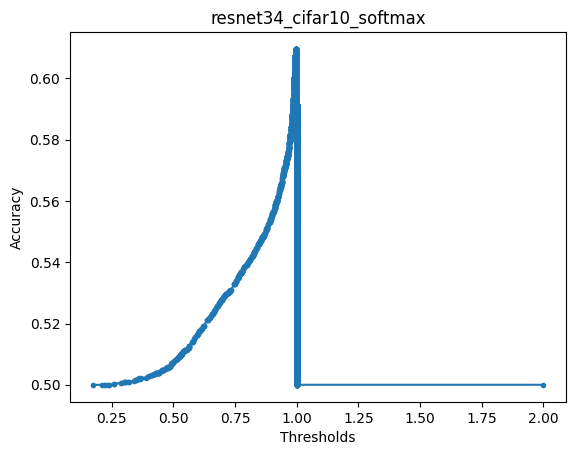

Max accuracy: 0.609, Thresholds -0.021963229402899742


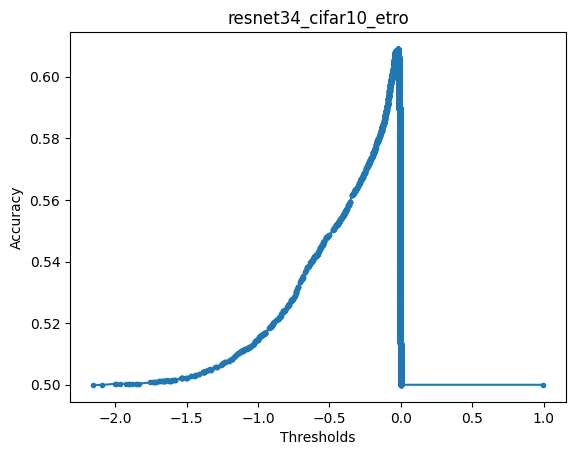

Max accuracy: 0.6173, Thresholds -2.4318695068359375e-05


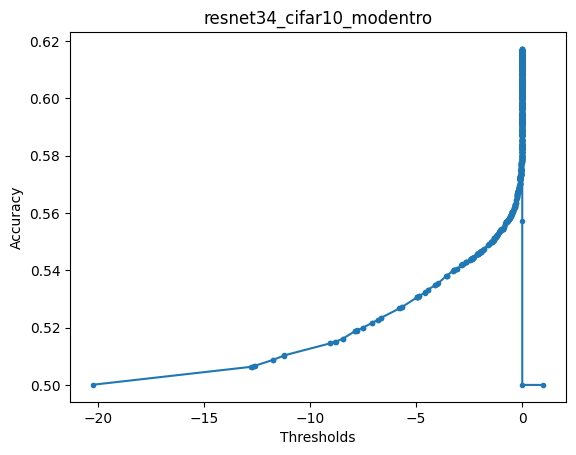

Max accuracy: 0.61725, Thresholds -0.004359147977083921


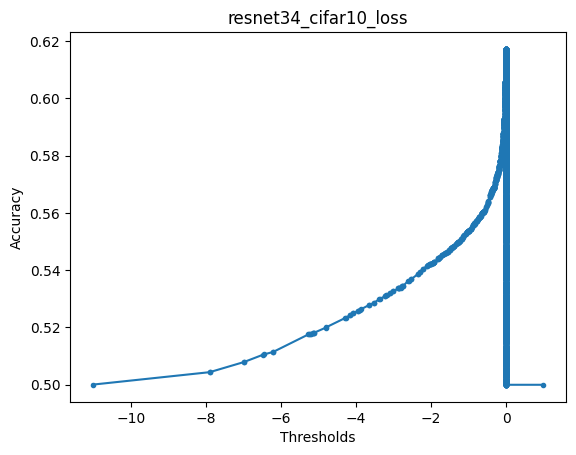

Processing resnet34 cifar100


100%|██████████| 200/200 [00:04<00:00, 46.48it/s]


Max accuracy: 0.77045, Thresholds 0.9745363593101501


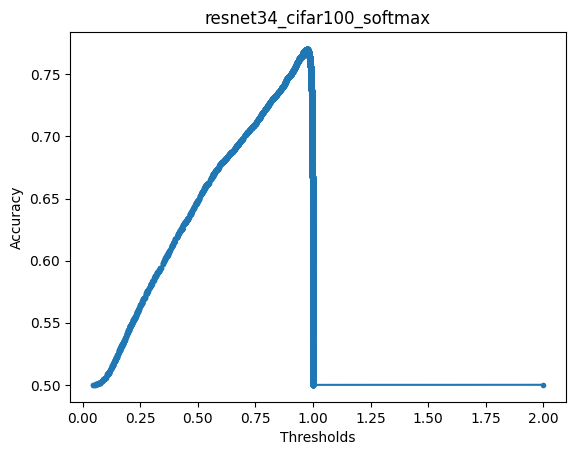

Max accuracy: 0.7693, Thresholds -0.22013235092163086


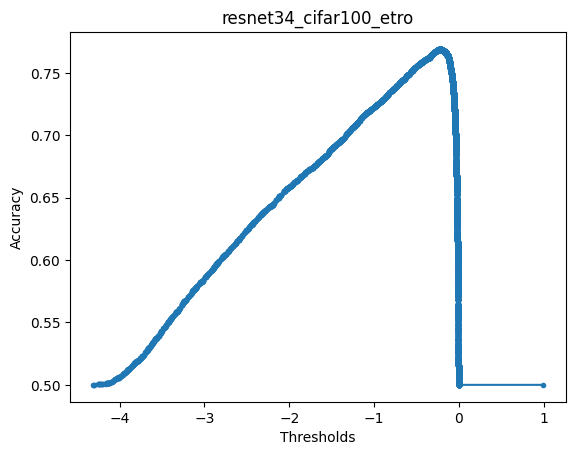

Max accuracy: 0.7829, Thresholds -0.0019989013671875


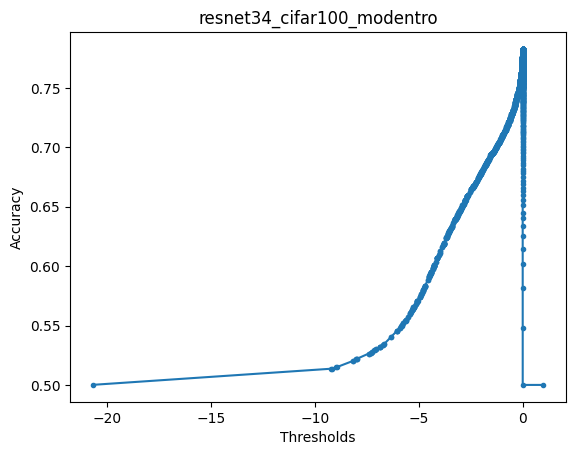

Max accuracy: 0.78235, Thresholds -0.0428120493888855


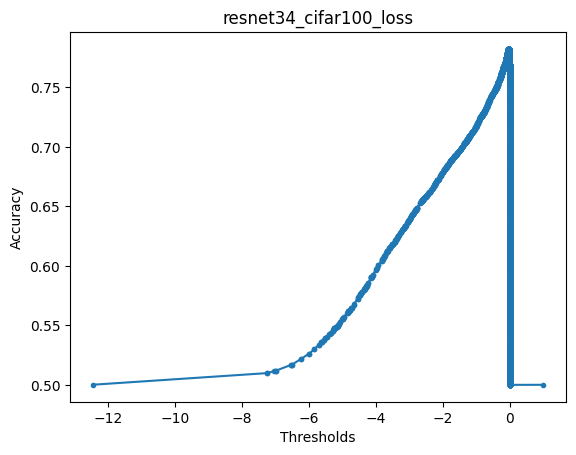

Processing resnet34 tinyimagenet


100%|██████████| 200/200 [00:15<00:00, 13.18it/s]


Max accuracy: 0.89435, Thresholds 0.9695436358451843


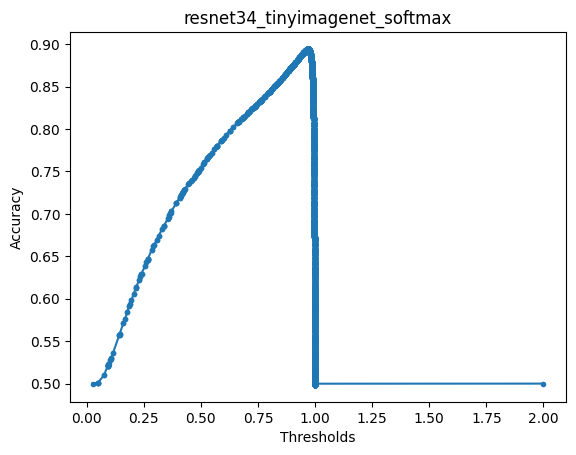

Max accuracy: 0.891, Thresholds -0.24537496268749237


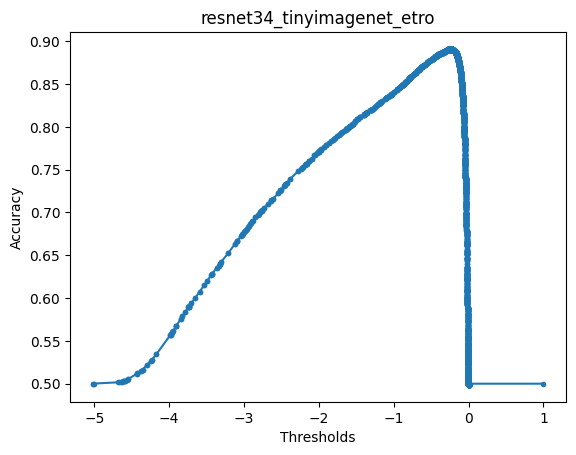

Max accuracy: 0.9003, Thresholds -0.001779317855834961


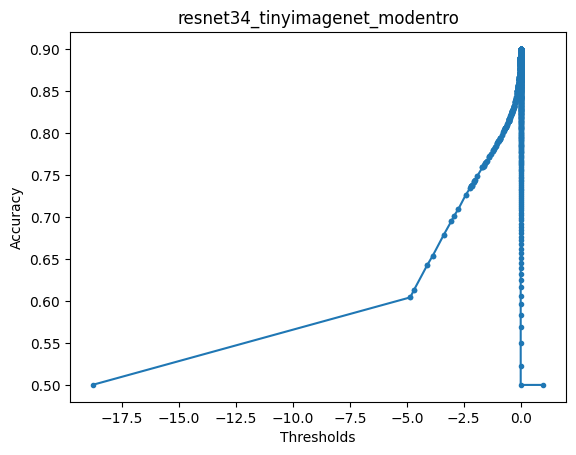

Max accuracy: 0.89955, Thresholds -0.03794684633612633


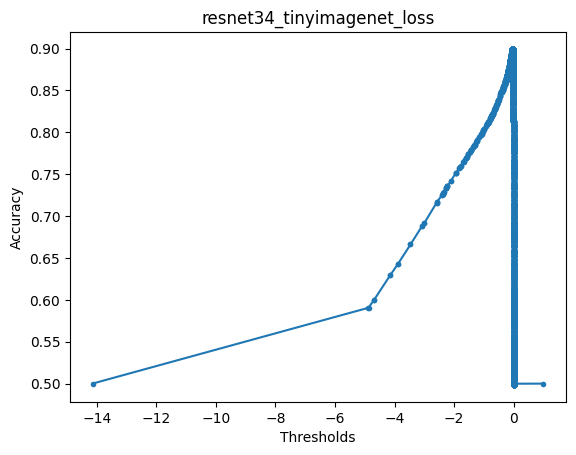

Processing vgg16 cifar10


100%|██████████| 200/200 [00:02<00:00, 88.45it/s] 


Max accuracy: 0.61255, Thresholds 0.9985809326171875


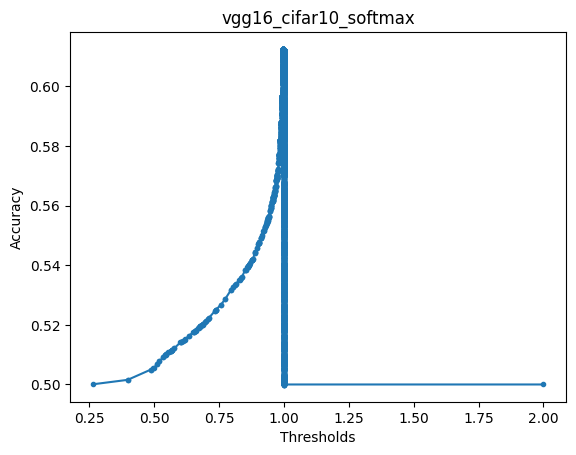

Max accuracy: 0.61215, Thresholds -0.011597528122365475


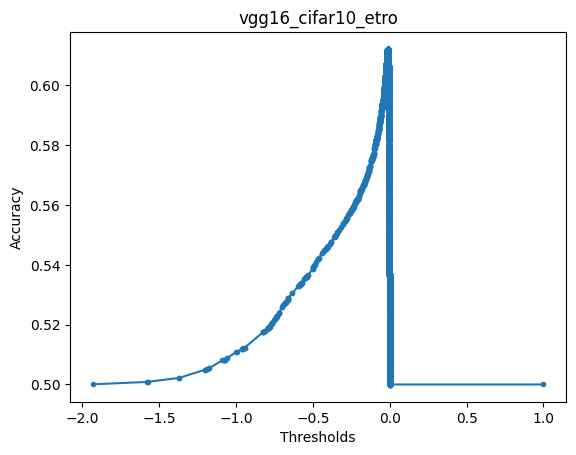

Max accuracy: 0.6218, Thresholds -5.245208740234375e-06


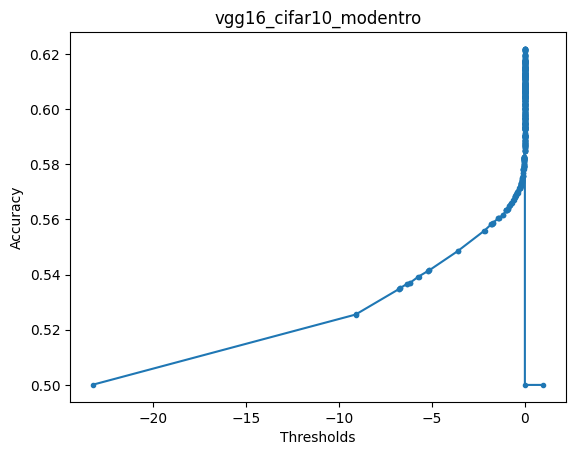

Max accuracy: 0.6216, Thresholds -0.0018848287872970104


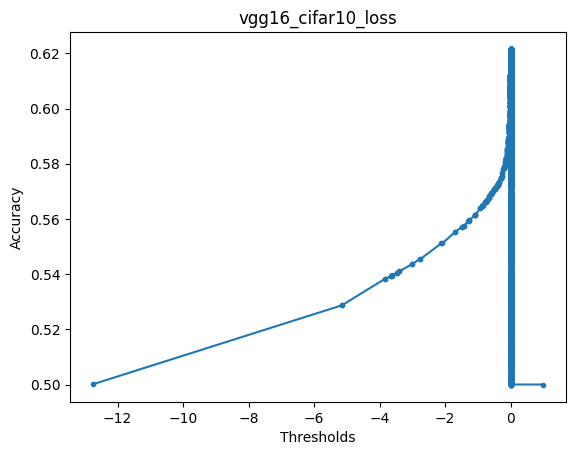

Processing vgg16 cifar100


100%|██████████| 200/200 [00:02<00:00, 94.72it/s] 


Max accuracy: 0.75195, Thresholds 0.989482045173645


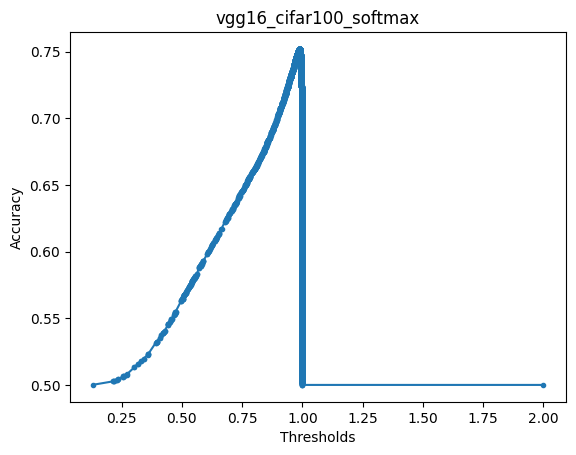

Max accuracy: 0.7516, Thresholds -0.08824557065963745


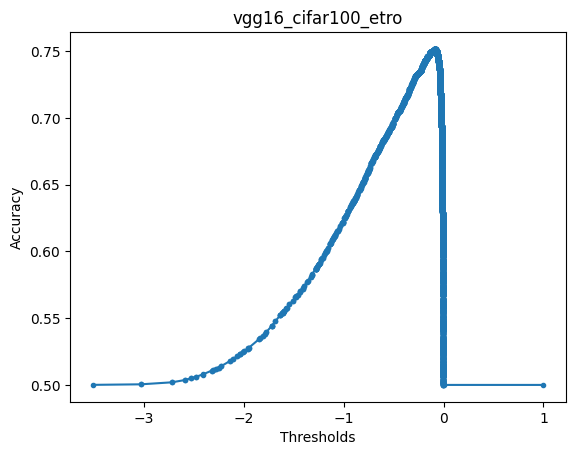

Max accuracy: 0.7793, Thresholds -0.0010967254638671875


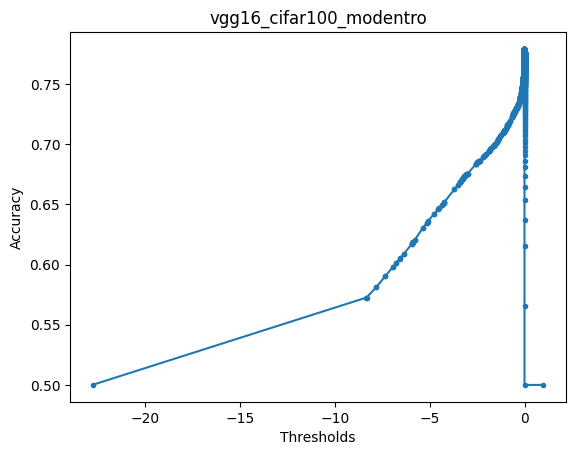

Max accuracy: 0.77925, Thresholds -0.023607837036252022


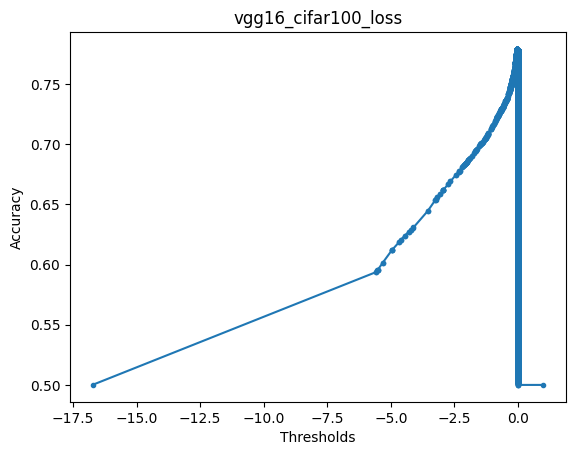

Processing vgg16 tinyimagenet


100%|██████████| 200/200 [00:05<00:00, 37.83it/s]


Max accuracy: 0.91645, Thresholds 0.9524933695793152


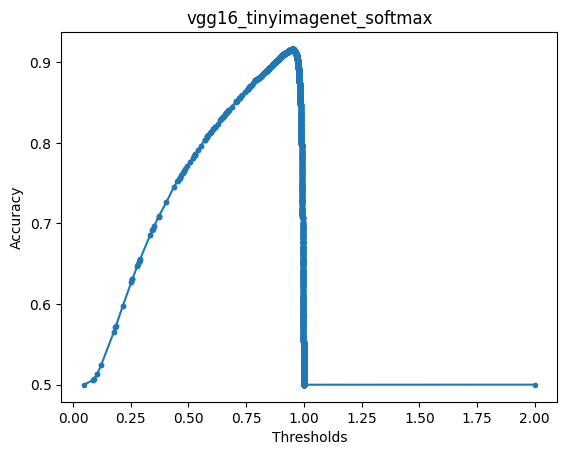

Max accuracy: 0.913, Thresholds -0.32602614164352417


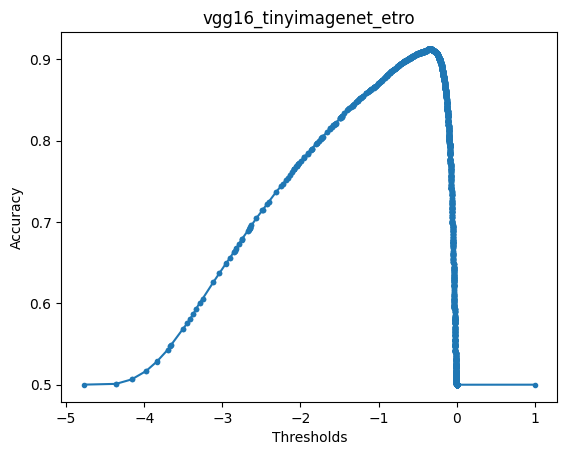

Max accuracy: 0.92365, Thresholds -0.004525661468505859


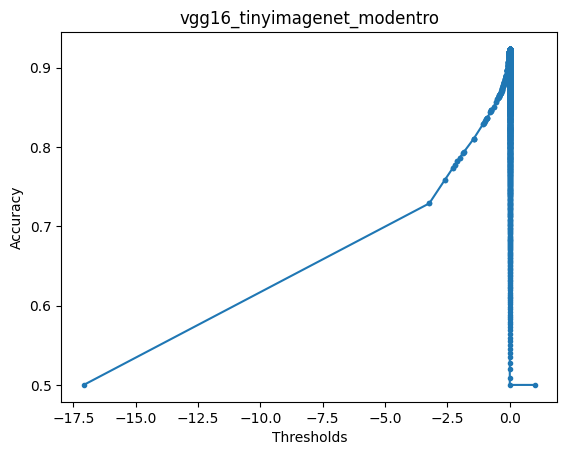

Max accuracy: 0.9229, Thresholds -0.06094803288578987


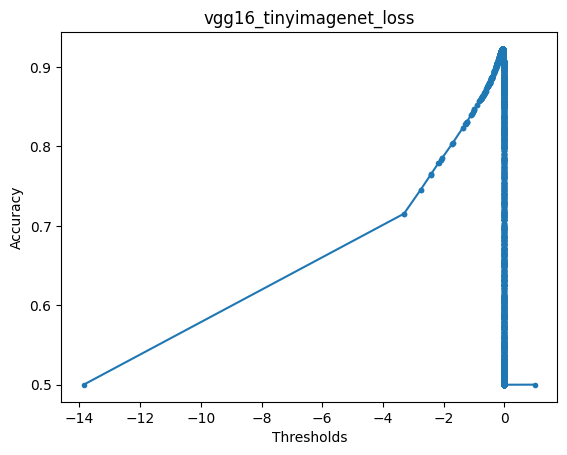

Processing mobilenetv2 cifar10


100%|██████████| 200/200 [00:05<00:00, 39.28it/s]


Max accuracy: 0.57935, Thresholds 0.9966122508049011


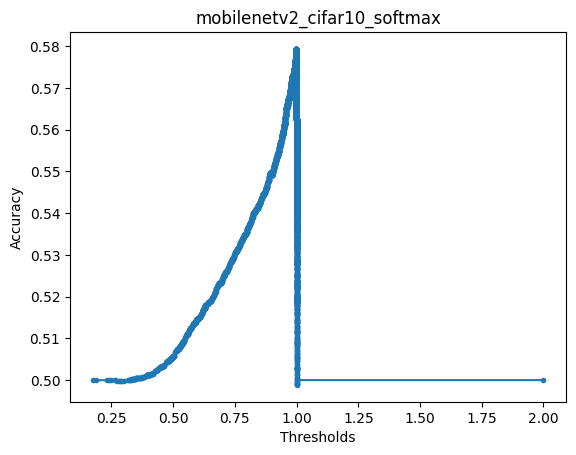

Max accuracy: 0.5788, Thresholds -0.022550512105226517


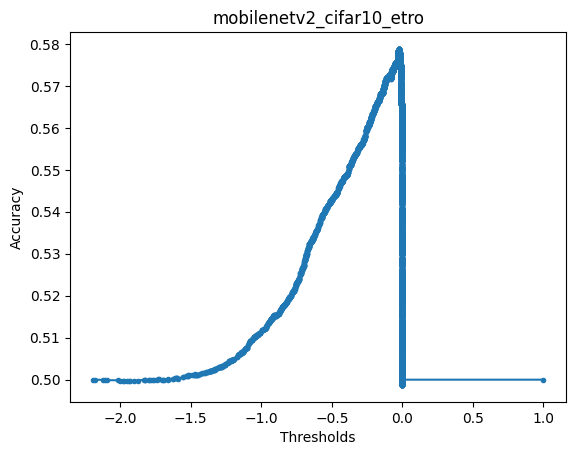

Max accuracy: 0.58775, Thresholds -0.0004940032958984375


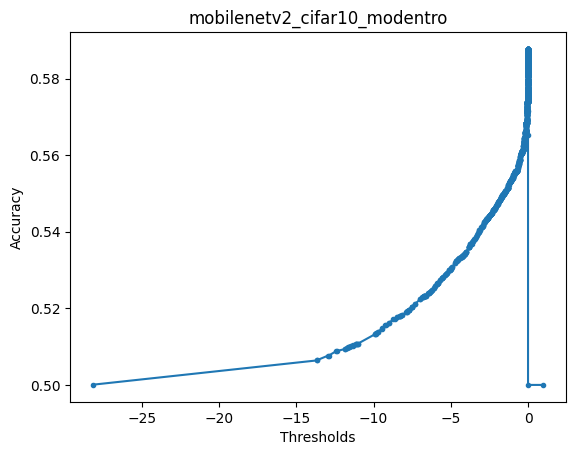

Max accuracy: 0.5875, Thresholds -0.02036869153380394


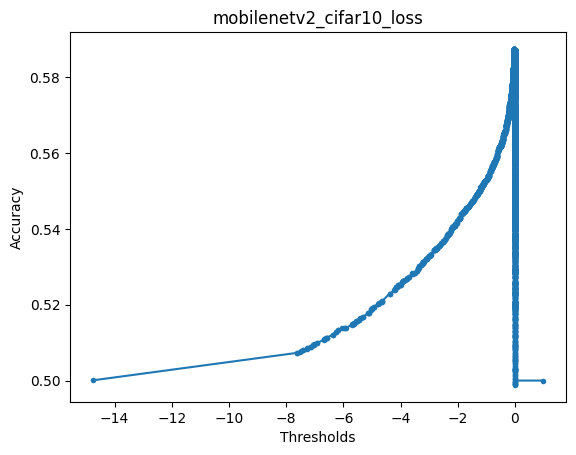

Processing mobilenetv2 cifar100


100%|██████████| 200/200 [00:03<00:00, 66.12it/s]


Max accuracy: 0.6939, Thresholds 0.9192230701446533


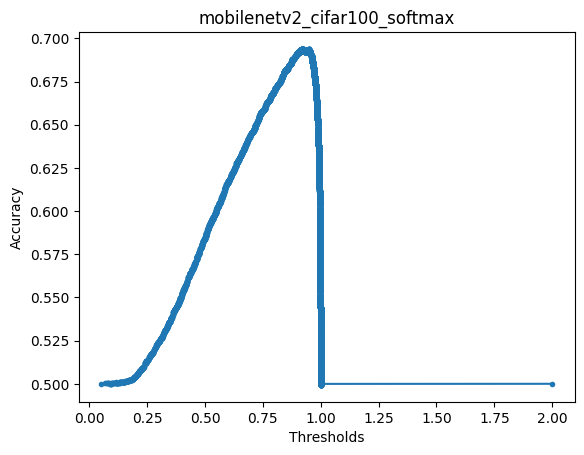

Max accuracy: 0.69155, Thresholds -0.31302669644355774


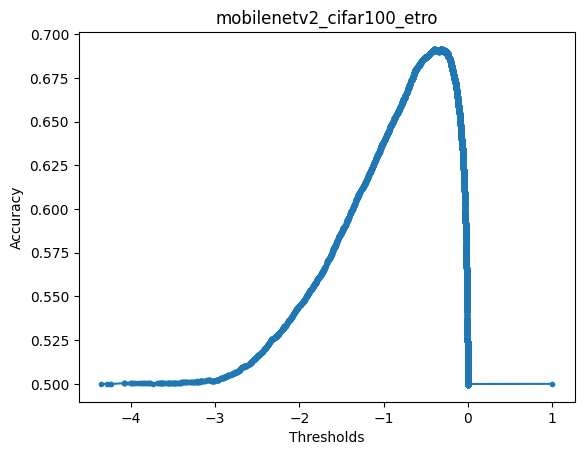

Max accuracy: 0.72255, Thresholds -0.023541927337646484


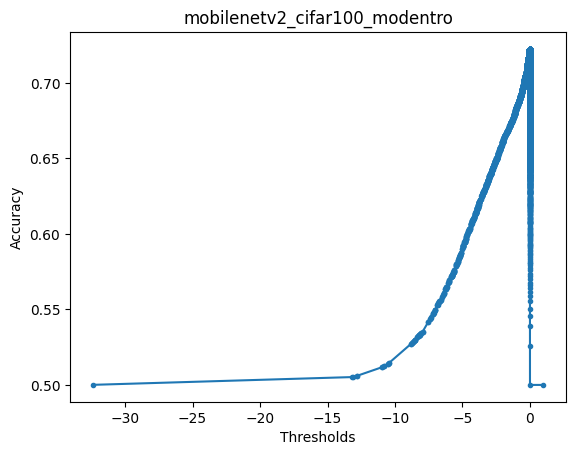

Max accuracy: 0.7224, Thresholds -0.16654260456562042


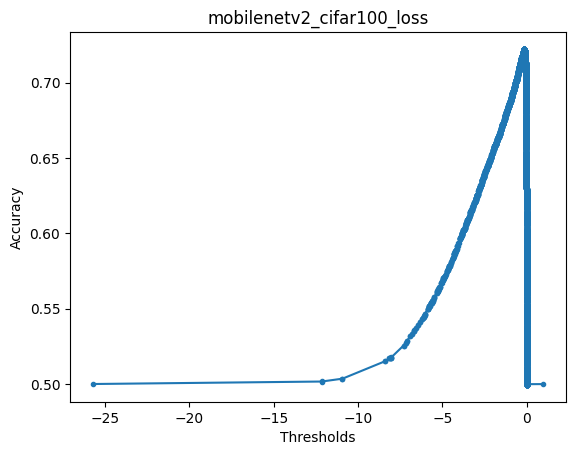

Processing mobilenetv2 tinyimagenet


100%|██████████| 200/200 [00:07<00:00, 25.16it/s]


Max accuracy: 0.82515, Thresholds 0.8850345611572266


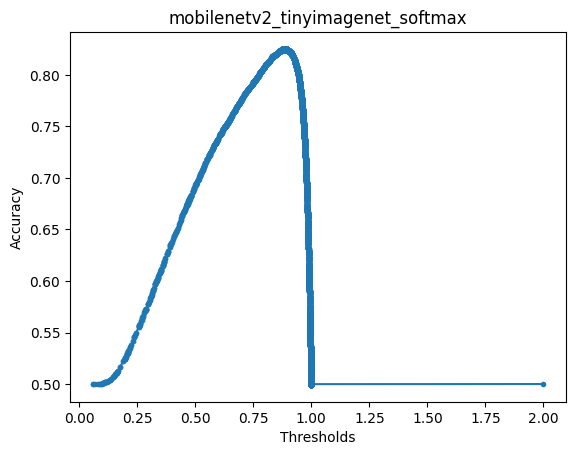

Max accuracy: 0.81665, Thresholds -0.5999271869659424


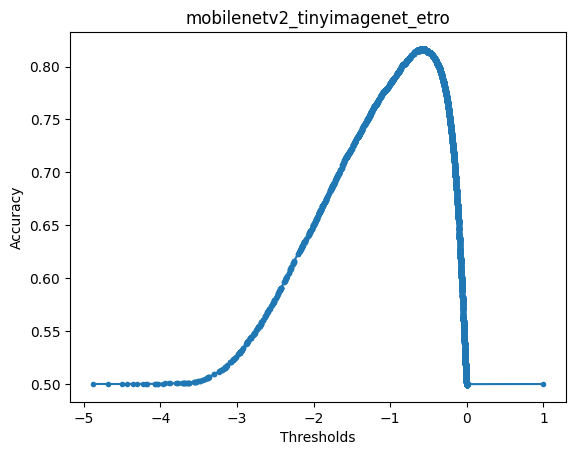

Max accuracy: 0.8475, Thresholds -0.033533573150634766


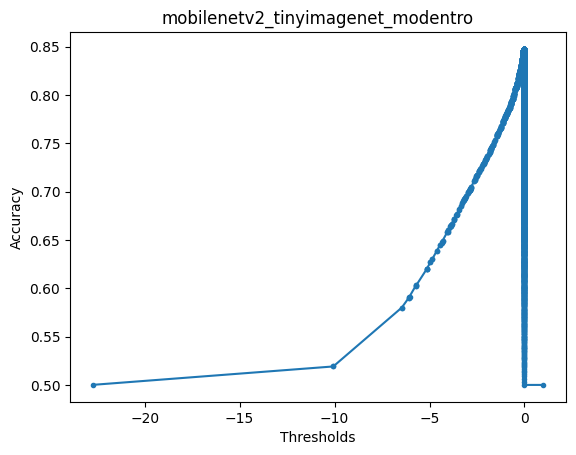

Max accuracy: 0.8461, Thresholds -0.18107567727565765


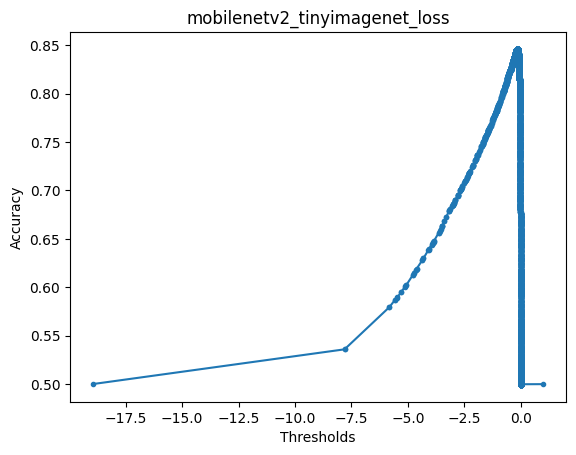

In [7]:
import json
results = defaultdict(dict)
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        print(f"Processing {model} {dataset}")
        results[model][dataset] = calc_data(model, dataset)

In [8]:
with open(f"{ROOT_DIR}/result.json", "w") as f:
    f.write(json.dumps(results))

In [9]:
with open(f"{ROOT_DIR}/result.json", "r") as f:
    results = json.load(f)

In [10]:
predictions = defaultdict(dict)
datas = defaultdict(dict)
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        print(f"Processing {model} {dataset}")
        data = calc_data_test(get_model(model, dataset), get_dset(model, dataset, "test"))
        datas[model][dataset] = data
        

Processing resnet34 cifar10


100%|██████████| 100/100 [00:02<00:00, 47.23it/s]


Processing resnet34 cifar100


100%|██████████| 100/100 [00:02<00:00, 41.15it/s]


Processing resnet34 tinyimagenet


100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


Processing vgg16 cifar10


100%|██████████| 100/100 [00:01<00:00, 69.25it/s]


Processing vgg16 cifar100


100%|██████████| 100/100 [00:01<00:00, 75.71it/s]


Processing vgg16 tinyimagenet


100%|██████████| 100/100 [00:02<00:00, 34.98it/s]


Processing mobilenetv2 cifar10


100%|██████████| 100/100 [00:01<00:00, 60.72it/s]


Processing mobilenetv2 cifar100


100%|██████████| 100/100 [00:01<00:00, 57.87it/s]


Processing mobilenetv2 tinyimagenet


100%|██████████| 100/100 [00:04<00:00, 21.64it/s]


In [11]:
import os
import glob

files = glob.glob(f'{ROOT_DIR}/results/*')
for f in files:
    os.remove(f)
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        print(f"Processing {model} {dataset}")
        data = datas[model][dataset]
        metric, res = max(results[model][dataset].items(), key = lambda x: x[1]["max_acc"])
        print(metric, res)
        thresh = res["threshold"]
        predictions[model][dataset] = data[metric] > thresh
        np.save(f"{ROOT_DIR}/results/task1_{model}_{dataset}.npy", predictions[model][dataset])
        np.save(f"{ROOT_DIR}/results/task2_{model}_{dataset}.npy", predictions[model][dataset])
        np.save(f"{ROOT_DIR}/results/task3_{model}_{dataset}.npy", data["correct"])

Processing resnet34 cifar10
modentro {'max_acc': 0.6173, 'threshold': -2.4318695068359375e-05}
Processing resnet34 cifar100
modentro {'max_acc': 0.7829, 'threshold': -0.0019989013671875}
Processing resnet34 tinyimagenet
modentro {'max_acc': 0.9003, 'threshold': -0.001779317855834961}
Processing vgg16 cifar10
modentro {'max_acc': 0.6218, 'threshold': -5.245208740234375e-06}
Processing vgg16 cifar100
modentro {'max_acc': 0.7793, 'threshold': -0.0010967254638671875}
Processing vgg16 tinyimagenet
modentro {'max_acc': 0.92365, 'threshold': -0.004525661468505859}
Processing mobilenetv2 cifar10
modentro {'max_acc': 0.58775, 'threshold': -0.0004940032958984375}
Processing mobilenetv2 cifar100
modentro {'max_acc': 0.72255, 'threshold': -0.023541927337646484}
Processing mobilenetv2 tinyimagenet
modentro {'max_acc': 0.8475, 'threshold': -0.033533573150634766}
